In [ ]:
import tensorflow as tf
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from operator import itemgetter
from IPython.display import Image, display
from collections import Counter
import PIL
from tqdm import tqdm
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model

In [ ]:
# Mounting the Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
final_train_df = pd.read_csv('/content/drive/MyDrive/Deep Learning Project/Navesha Palmer/Data/Files/Label.csv')

In [ ]:
final_train_df['ImagePath_Png'] = '/content/drive/MyDrive/Deep Learning Project/Navesha Palmer/Data/Files/PNG Images/Images/'+ final_train_df['ImageId']+'.jpg'

In [ ]:
Paths = final_train_df['ImagePath_Png']

In [ ]:
Path_List = []

for path in Paths:
  Path_List.append(path)

Path_List

In [ ]:
last_conv_layer_name = "conv5_block16_concat"

In [ ]:
from tensorflow.keras.models import load_model
Savedmodel=load_model('/content/drive/MyDrive/Deep Learning Project/Navesha Palmer/Code/FinalNet.h5')

new approach

In [ ]:
IMAGE_SIZE = (256, 256)
def get_img_array(img_path, size=IMAGE_SIZE):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 NumPy array
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 180, 180, 3)
    array = np.expand_dims(array, axis=0)
    return array


In [ ]:
def make_gradcam_heatmap(img_array, model):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.layers[425]D
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Mark the classifying layers
    classifier_layers = model.layers[-9:]

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for classifier_layer in classifier_layers:
        x = classifier_layer(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

     # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


SyntaxError: ignored

In [ ]:
def superimposed_cam(file_path):
    # Prepare image
    img_array = get_img_array(file_path)

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(
        img_array, Savedmodel
    )

    # Rescale the original image
    img = img_array * 255

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img[0])

    return superimposed_img, CLASSES[np.argmax(Savedmodel.predict(img_array))]

In [ ]:
Pneumothorax = tf.io.gfile.glob('/content/drive/MyDrive/Deep Learning Project/Navesha Palmer/Data/Files/TestSorted/Pos/*')
No_Pneumothorax = tf.io.gfile.glob('/content/drive/MyDrive/Deep Learning Project/Navesha Palmer/Data/Files/TestSorted/Neg/*')

In [ ]:
layer_amount = Savedmodel.layers[425]
layer_amount

In [ ]:
CLASSES = ['NO PNEU', 'Pneu']

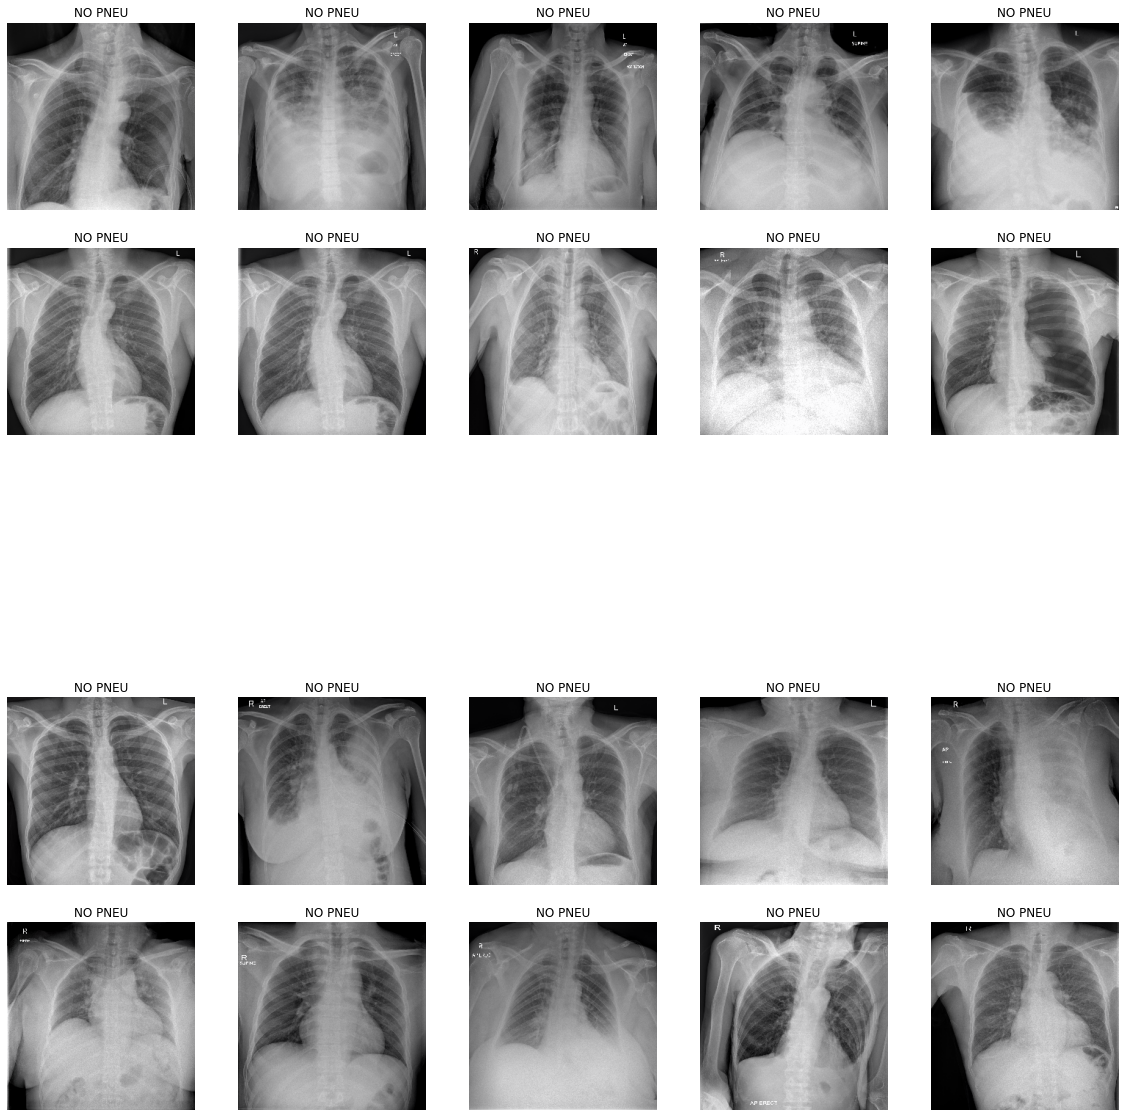

In [ ]:
plt.figure(figsize=(20,20))
for n in range(10):
    ax = plt.subplot(5,5,n+1)
    img, pred = superimposed_cam(Pneumothorax[n])
    plt.imshow(img)
    plt.title(pred)
    plt.axis("off")
for n in range(15, 25):
    ax = plt.subplot(5,5,n+1)
    img, pred = superimposed_cam(No_Pneumothorax[n])
    plt.imshow(img)
    plt.title(pred)
    plt.axis("off")

In [ ]:
# Grad-CAM for model interpretability
# https://keras.io/examples/vision/grad_cam/
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 256x256
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (256, 256, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 256, 256, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    #target_layer = model.get_layer(find_target_layer())
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [ ]:
def find_target_layer():
  for layer in reversed(Savedmodel.layers):
    if len(layer.output_shape) == 4:
      return layer.name

In [ ]:
Test_df = pd.read_csv('/content/drive/MyDrive/Deep Learning Project/Navesha Palmer/Data/Files/Results.csv')
Test_df.head()

,Label,Age,Sex,line/tubes,Ground truth,QC result,Physician 1,Physician 2,Size,ImagePath_jpg,AI Model Prediction Probability,AI Model Prediction
0,DX001,68.0,M,N,NEG,NEG,Positive,Negative,NaN,/content/drive/MyDrive/Deep Learning Project/N...,0.960245,POS
1,DX002,62.0,M,N,NEG,NEG,Positive,Negative,NaN,/content/drive/MyDrive/Deep Learning Project/N...,0.000004,NEG
2,DX003,67.0,F,Y,POS,POS,Positive,Negative,Large,/content/drive/MyDrive/Deep Learning Project/N...,0.883043,POS
3,DX004,68.0,M,N,NEG,NEG,Negative,Negative,NaN,/content/drive/MyDrive/Deep Learning Project/N...,0.000381,NEG
4,DX005,51.0,M,Y,NEG,NEG,Negative,Negative,NaN,/content/drive/MyDrive/Deep Learning Project/N...,0.000003,NEG


In [ ]:
Test_path = []
Truth = []
Prediction = []
Label = []

for i in Test_df["ImagePath_jpg"]:
  Test_path.append(i)

for i in Test_df["Ground truth"]:
  Truth.append(i)

for i in Test_df["AI Model Prediction"]:
  Prediction.append(i)

for i in Test_df["Label"]:
  Label.append(i)

In [ ]:
Test_df["ImagePath_jpg"][0]

'/content/drive/MyDrive/Deep Learning Project/Navesha Palmer/Data/Test/DX001.jpg'

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

img_size = (256,256)

for i, ax in enumerate(axes.flat):
    img_size = (256,256)
    img_path = Test_df["ImagePath_jpg"][i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, Savedmodel, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    #ax.imshow(plt.imread(cam_path))
    ax.set_title(f"Image ID: {Label[i]}\nTrue: {Truth[i]}\nPredicted: {Prediction[i]}")

plt.tight_layout()
#plt.show()

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"


In [ ]:
path = Test_df["ImagePath_jpg"][0]


# Prepare image
img_array = preprocess_input(get_img_array(path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(path, heatmap)

In [ ]:
def build_decoder(with_labels=True, target_size=(300, 300)):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        img = tf.image.decode_png(file_bytes, channels=3)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img

    def decode_with_labels(path, label):
        return decode(path), label

    return decode_with_labels if with_labels else decode

def build_augmenter(with_labels=True):
    def augment(img):
        number = random.randint(1,5)
        seed = (1, 5)
        if number == 1:
            img = tf.image.stateless_random_flip_left_right(img,seed)
            img = tf.image.stateless_random_contrast(img,0.2, 0.5,seed)
        if number == 2:
            img = tf.image.stateless_random_flip_up_down(img,seed)
            img = tf.image.stateless_random_brightness(img, 0.2,seed)
        if number == 3:
            img = tf.image.stateless_random_flip_left_right(img,seed)
            img = tf.image.stateless_random_saturation(img, 0.2, 0.5,seed)
        if number == 4:
            img = tf.image.stateless_random_flip_up_down(img,seed)
            img = tf.image.stateless_random_hue(img, 0.2,seed)
        if number == 5:
            img = tf.image.stateless_random_flip_left_right(img,seed)
            img = tf.image.adjust_gamma(img, 0.2)
        return img

    def augment_with_labels(img, label):
        return augment(img), label

    return augment_with_labels if with_labels else augment

def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024,cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)

    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)

    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)

    return dset


In [ ]:
from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
#from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import keras
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
import random as rn
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, Callback
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# import tensorflow.keras.applications.efficientnet as efn
from tensorflow.keras import Sequential
from keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D

from tensorflow import reduce_sum
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Dropout, concatenate, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split


#Defining the model:
base_model = densenet.DenseNet121(weights = None, include_top=False, input_shape=(256,256,3))

#Adding a dummy layer so that pre-trained weights can be loaded properly. This dummy layer is removed later
predictions = tf.keras.layers.Dense(14,activation='sigmoid', name='predictions')(base_model.output)

base_model2 = tf.keras.Model(inputs = base_model.input, outputs = predictions)

#Loading the pre-trained chexnet weights
base_model2.load_weights('/content/drive/MyDrive/Deep Learning Project/Navesha Palmer/Code/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')
#base_model2.load_weights('/content/drive/MyDrive/Deep Learning Project/Navesha Palmer/Code/FinalNet.h5')

#Removing the dummy layer
base_model2.layers.pop()

#Freezing the model
#base_model2.trainable = False

#Adding a pooling layer
new_base_model = tf.keras.layers.GlobalAveragePooling2D()(base_model2.layers[-3].output)

new_base_model = tf.keras.layers.Dense(1024, activation='relu')(new_base_model)
new_base_model = tf.keras.layers.BatchNormalization()(new_base_model)
new_base_model = tf.keras.layers.Dropout(0.4)(new_base_model)

new_base_model = tf.keras.layers.Dense(512, activation='relu')(new_base_model)
new_base_model = tf.keras.layers.BatchNormalization()(new_base_model)
new_base_model = tf.keras.layers.Dropout(0.4)(new_base_model)

new_base_model = tf.keras.layers.Dense(64, activation='relu')(new_base_model)

#Adding the final Dense layer for prediction
new_base_model = tf.keras.layers.Dense(1, activation='sigmoid')(new_base_model)

#Model built
final_new_model = tf.keras.Model(base_model2.input, new_base_model)

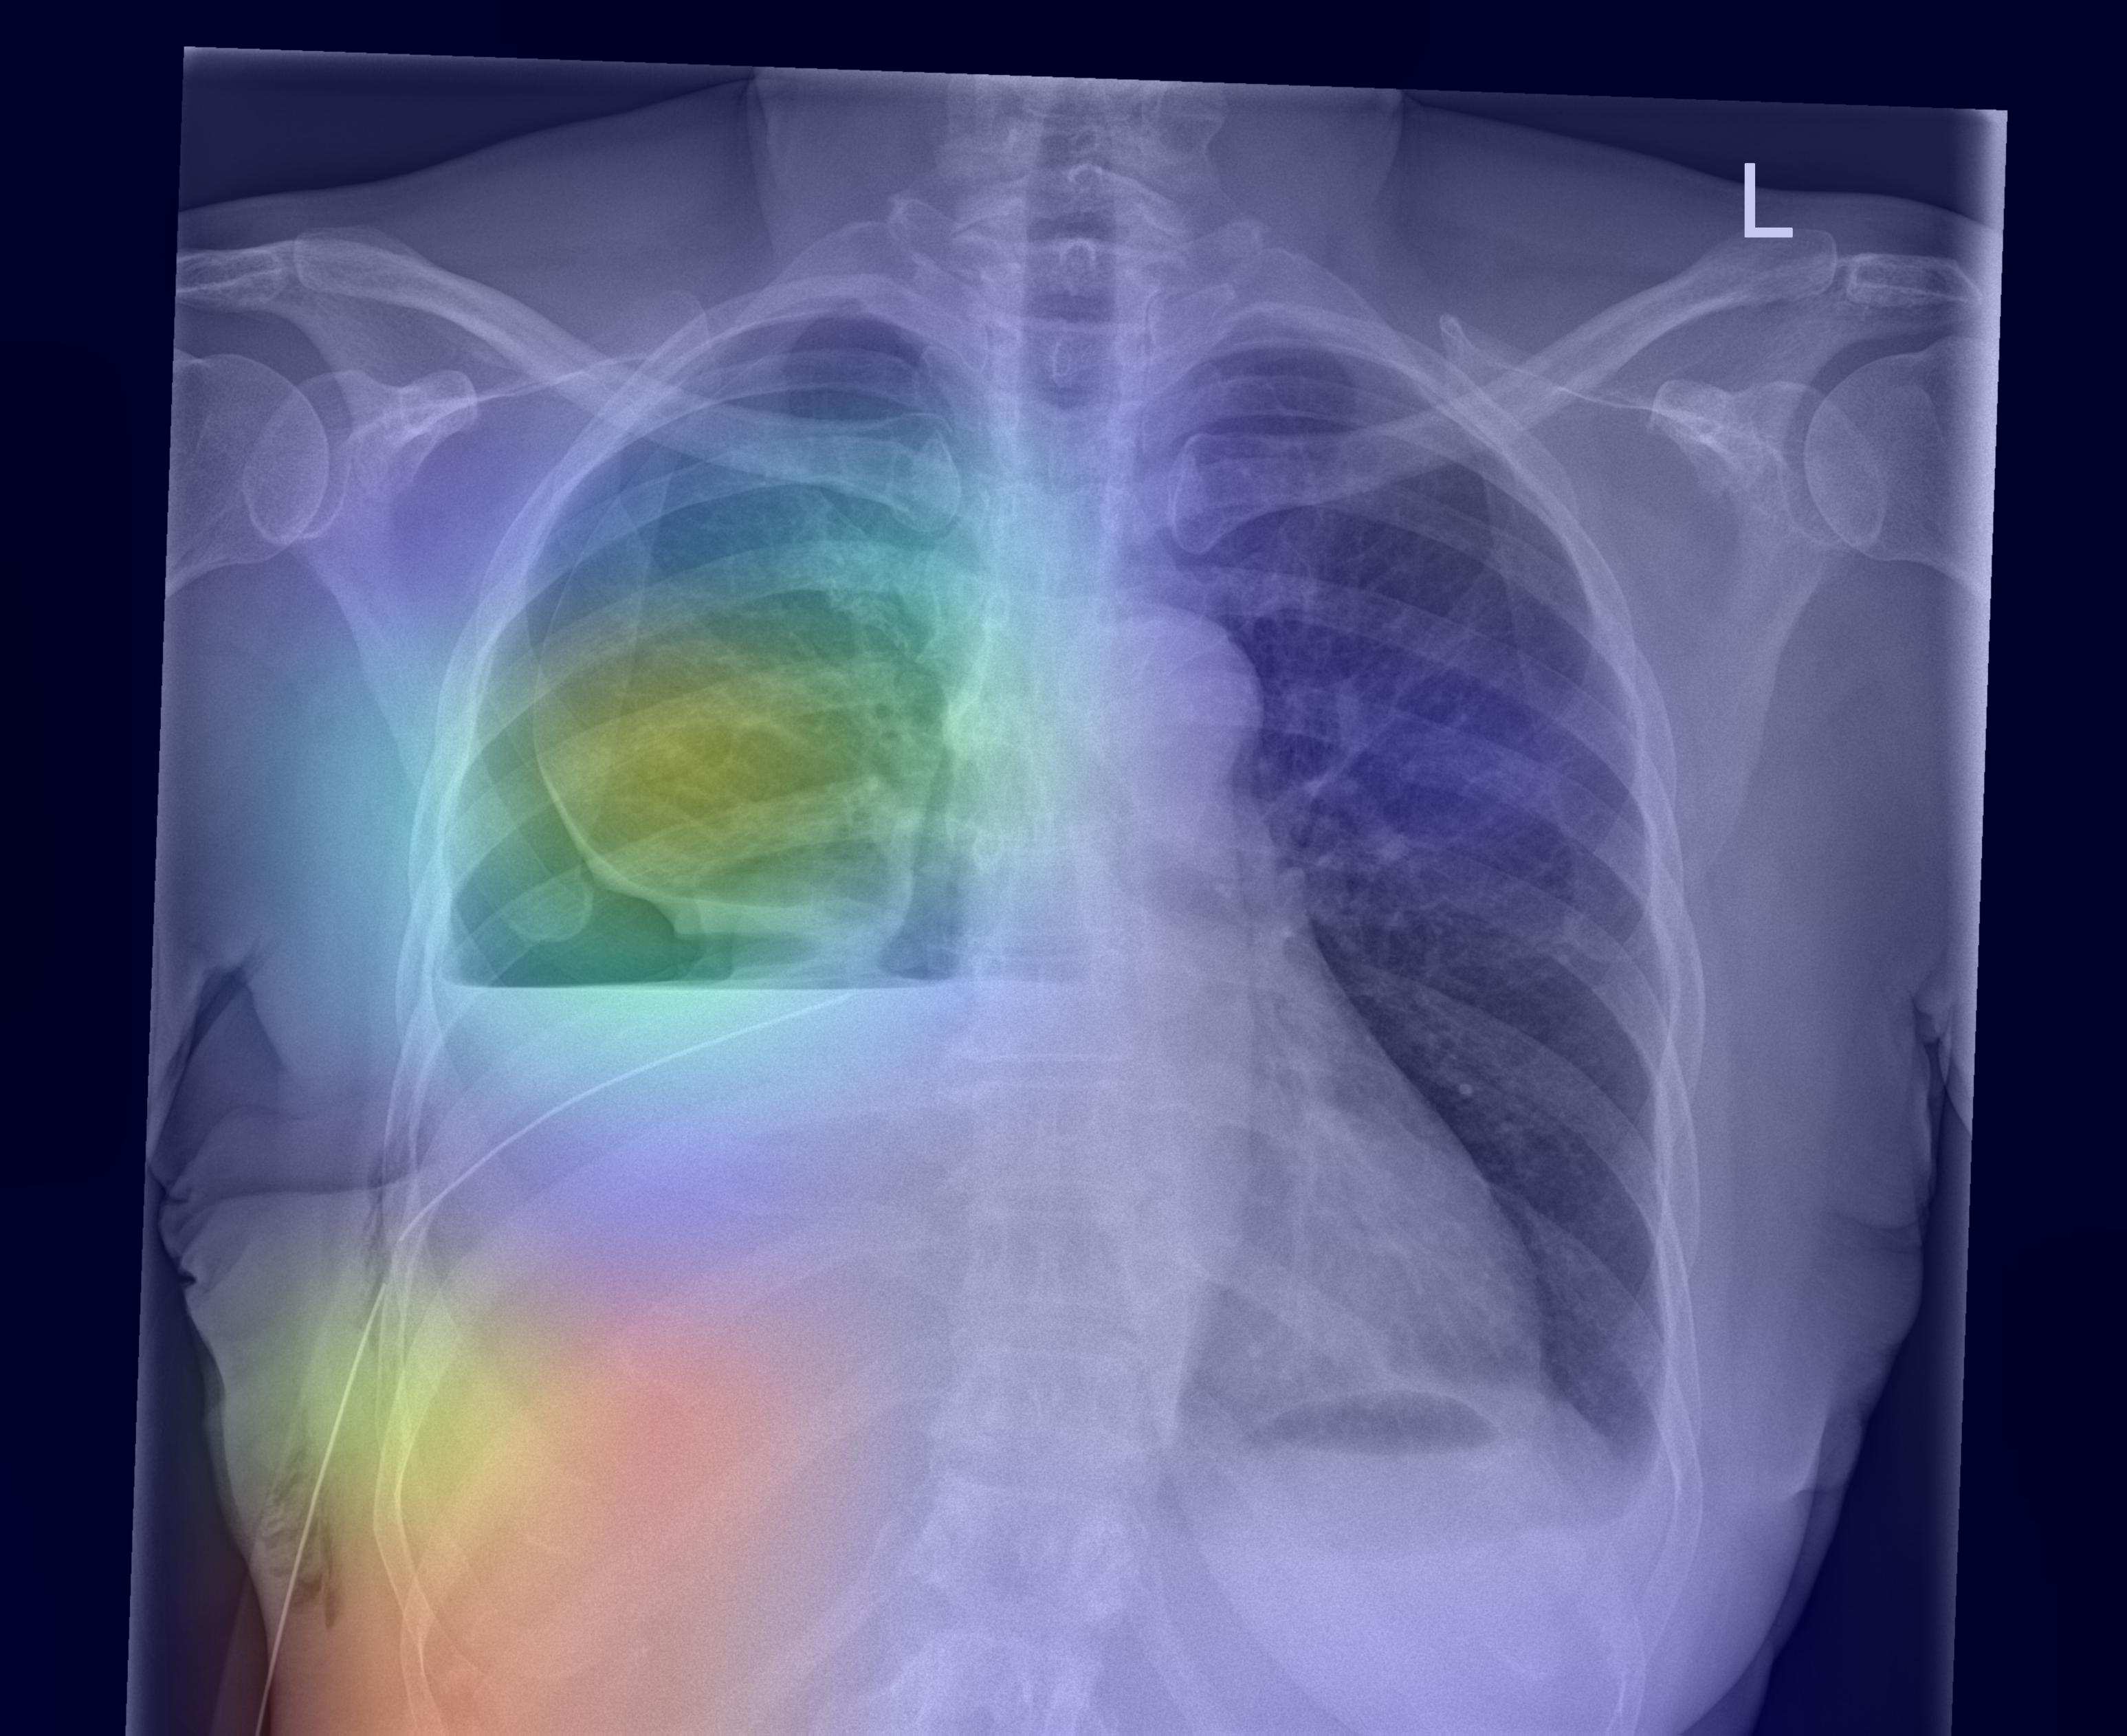

In [ ]:
from tensorflow import keras
path = Test_df["ImagePath_jpg"][45]
BATCH_SIZE = 16
img_size = (256,256)

preprocess_input = keras.applications.densenet.preprocess_input
decode_predictions = keras.applications.densenet.decode_predictions

last_conv_layer_name = 'conv5_block16_concat'
final_new_model.layers[-1].activation = None
#display(Image(path))



# Prepare image
img_array = preprocess_input(get_img_array(path, size=img_size))

preds = final_new_model.predict(img_array)


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, final_new_model, last_conv_layer_name)

# Display heatmap
#plt.matshow(heatmap)
#plt.show()

save_and_display_gradcam(path, heatmap)

In [ ]:
preds

array([[0.09407348]], dtype=float32)